In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams.update({'font.size': 25, 'legend.fontsize': 20, 'axes.titlesize': 24})
plt.style.use('classic')

Text(0, 0.5, 'y positions')

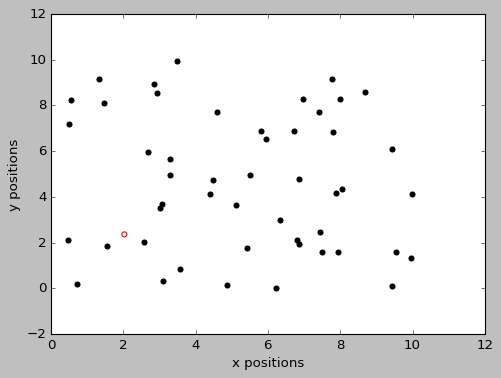

In [2]:
# Generate the stop points
scale = 10
num_stop = 50
stop_x = np.random.rand(num_stop) * scale
stop_y = np.random.rand(num_stop) * scale

class stops:
    def __init__(self, num:int, xpos, ypos):
        self.name = 'stop' + str(num)
        self.num = num
        self.xpos = xpos
        self.ypos = ypos
        self.done = False

fig, vanilla = plt.subplots(1, 1, figsize = (7, 5))

for i in range(num_stop):
    globals()[f'stop{i}'] = stops(i, stop_x[i], stop_y[i])
    if i == 0:
        vanilla.scatter(stop_x[i], stop_y[i], edgecolors = 'red', facecolors = 'none')
        #vanilla.annotate(f'{i}', [stop_x[i] + 0.1, stop_y[i] + 0.1], color = 'red')
    else:
        vanilla.scatter(stop_x[i], stop_y[i], color = 'black')
        #vanilla.annotate(f'{i}', [stop_x[i] + 0.1, stop_y[i] + 0.1], color = 'black')

vanilla.set_xlabel("x positions")
vanilla.set_ylabel("y positions")

In [3]:
def find_length (stop, next_stop):
    dx = next_stop.xpos - stop.xpos
    dy = next_stop.ypos - stop.ypos
    
    return (dx**2 + dy**2)**0.5

In [4]:
def run_program(trial_num = 0):
    import os
    try:
        os.mkdir('Path Plots')
    except OSError:
        pass
    
    # Generate the background plot
    fig, vanilla = plt.subplots(1, 1, figsize = (7, 5))

    for i in range(num_stop):
        globals()[f'stop{i}'] = stops(i, stop_x[i], stop_y[i])
        if i == 0:
            vanilla.scatter(stop_x[i], stop_y[i], color = 'red')
            vanilla.annotate(f'{i}', [stop_x[i] + 0.1, stop_y[i] + 0.1], color = 'red')
        else:
            vanilla.scatter(stop_x[i], stop_y[i], color = 'black')
            vanilla.annotate(f'{i}', [stop_x[i] + 0.1, stop_y[i] + 0.1], color = 'black')

    vanilla.set_xlabel("x positions")
    vanilla.set_ylabel("y positions")
    vanilla.set_title(f'Trial {trial_num}')

    # conduct Monte Carlo method to find the shorted path
    from timeit import default_timer

    list_stops = list(range(num_stop))

    start_stop_num = 0
    total_length = 0

    loops_counter = 0

    list_stops_temp = list(range(num_stop))

    start_stop =  globals()[f'stop{start_stop_num}']
    list_stops_temp.remove(start_stop.num)

    total_attempt = 0

    history_stops = [start_stop_num]

    start = default_timer()

    while True:
        """Before making each step, take a random guess at which stop is closer. Then make at most max_tries guesses
        and compare them with the first random guess, each failed candidate gets eliminated. The moment a shorter 
        path shows up, eliminate the reference one and set the new one as reference. Run the random guess process again
        with the new reference. When the list of candidates has been reduced to 1, set that one as the next stop. 

        """
        print (f'loop {loops_counter} starts, starting from stop {start_stop_num}')
        # print (list_stops_temp)
        loop_attempt = 0
        # prep the start stop 
        start_stop = globals()[f'stop{start_stop_num}']


        # Find and prep the next stop
        ref_num = list_stops_temp[int(np.random.rand() * len(list_stops_temp))]
        ref_stop = globals()[f'stop{ref_num}']

        ref_dist = find_length(start_stop, ref_stop)

        ref_list_stops = list_stops_temp.copy()
        tries = 0

        ref_list_stops.remove(ref_num)

        max_tries = max(int(0.2 * len(list_stops_temp)), 4)

        while tries < max_tries:
            """In each try, generate a test path and evaluate its distance. If the test distance is longer than the 
            reference distance, eliminate the test candidate. If the test distance is shorter than the reference distance,
            eliminate the referenece and establish the test as the (new) reference. When the number of tries run out, 
            the remaining reference path leads to the next stop. 
            """
            remaining_num = len(ref_list_stops)

            #print (remaining_num, ref_list_stops)

            if remaining_num <= 2:
                """If there are less than or equal to 2 candidates, use brute force"""
                #tries = max_tries + 1
                candi_dists = []
                for i in range(remaining_num):
                    candidate = globals()[f'stop{ref_list_stops[i]}']
                    candi_dists.append(find_length(start_stop, candidate))

                leap_dist = min(candi_dists)

                break

            temp = int(np.random.rand() * remaining_num)
            test_num = ref_list_stops[temp]
            test_stop = globals()[f'stop{test_num}']

            test_dist = find_length(start_stop, test_stop)
            loop_attempt += 1
            total_attempt += 1

            print (f'Tries {tries}/{max_tries}, {ref_num}-{test_num}. ref list length = {remaining_num}, dist = {test_dist}')

            if test_dist < ref_dist:
                """If the new guess is closer than the reference guess, eliminate the reference guess, set the 
                new guess as the (new) reference guess, reset tries, start over
                """
                ref_num = test_num
                ref_stop = globals()[f'stop{list_stops[ref_num]}']
                ref_dist = test_dist
                tries = 0 
                ref_list_stops.remove(ref_num)

            elif test_dist > ref_dist:
                """If the new guess is further than referene guess, eliminate the new guess"""
                ref_list_stops.remove(test_num)

            else:
                raise ValueError('The impossible has occured')

            leap_dist = ref_dist

            tries += 1

        vanilla.plot([start_stop.xpos, ref_stop.xpos], [start_stop.ypos, ref_stop.ypos], color = 'green')

        temp_name = start_stop.name
        start_stop = ref_stop
        start_stop_num = ref_stop.num
        list_stops_temp.remove(start_stop_num)
        history_stops.append(start_stop.num)

        total_length += leap_dist

        loops_counter += 1
        print(f'{len(list_stops_temp)} stops remaining. Jumped {leap_dist} from {temp_name} to {ref_stop.name}.')
        print(f'This loop made {loop_attempt}/{total_attempt} tries. Total distance now is {total_length}. {len(ref_list_stops)}/{len(list_stops_temp)} candidates not considered')
        print (f'Remaining stops: {list_stops_temp}')
        print (' ')

        if len(list_stops_temp) == 1:
            loop_attempt = 0
            break

    fig.savefig(f'Path Plots/Trial {trial_num}')

    final_stop = globals()[f'stop{list_stops_temp[0]}']
    total_length += find_length(start_stop, final_stop)
    vanilla.plot([start_stop.xpos, final_stop.xpos], [start_stop.ypos, final_stop.ypos], color = 'orange')

    stop = default_timer()

    runtime = stop - start

    print (f'There had been {total_attempt} tries. The total distane is {total_length}')
    print (f'The run time for the above is {runtime}')

    return total_attempt, total_length, runtime

loop 0 starts, starting from stop 0
Tries 0/9, 34-29. ref list length = 48, dist = 5.728366869752151
Tries 1/9, 34-4. ref list length = 47, dist = 7.743902942160141
Tries 2/9, 34-24. ref list length = 46, dist = 7.693896287783877
Tries 3/9, 34-49. ref list length = 45, dist = 1.5785409905198298
Tries 1/9, 49-20. ref list length = 44, dist = 2.9552160821197515
Tries 2/9, 49-32. ref list length = 43, dist = 5.415181269269214
Tries 3/9, 49-28. ref list length = 42, dist = 4.345491004684476
Tries 4/9, 49-8. ref list length = 41, dist = 8.403032983484303
Tries 5/9, 49-12. ref list length = 40, dist = 7.607432156438165
Tries 6/9, 49-21. ref list length = 39, dist = 5.776355491447851
Tries 7/9, 49-40. ref list length = 38, dist = 8.143568616969189
Tries 8/9, 49-46. ref list length = 37, dist = 7.294574177268598
48 stops remaining. Jumped 1.5785409905198298 from stop0 to stop49.
This loop made 12/12 tries. Total distance now is 1.5785409905198298. 36/48 candidates not considered
Remaining stop

(335, 136.00232982280497, 0.14432550000492483)

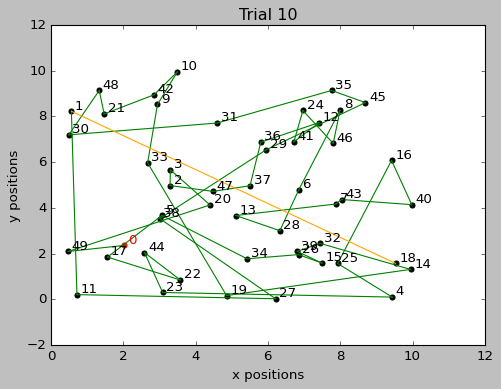

In [5]:
run_program(10)